In [56]:
from __future__ import print_function
import os
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [78]:
class Opts():
    def __init__(self):
        self.train_data_path = "./working/train/"
        self.test_data_path = "./working/test/"
        self.csv_path = "./meta"
        self.data_path = "./data/"
        self.model_save_path = "./output/"
        self.model_name = "cnn.h5"
        self.layer_name = "conv2d_20"
        self.plot_save_path = "./plot/cnn"
        
        if not os.path.exists(self.plot_save_path):
            os.mkdir(self.plot_save_path)
opts = Opts()


In [4]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calculate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

In [16]:
model = load_model(os.path.join(opts.model_save_path, opts.model_name))

In [23]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict

{'activation_24': <keras.layers.core.Activation at 0xb27d1a828>,
 'activation_25': <keras.layers.core.Activation at 0xb27dc0860>,
 'activation_26': <keras.layers.core.Activation at 0xb27d1a7f0>,
 'activation_27': <keras.layers.core.Activation at 0xb27e3cf60>,
 'activation_28': <keras.layers.core.Activation at 0xb27e68be0>,
 'activation_29': <keras.layers.core.Activation at 0xb27eb2f98>,
 'activation_30': <keras.layers.core.Activation at 0xb27f25828>,
 'conv2d_20': <keras.layers.convolutional.Conv2D at 0xb27d1a908>,
 'conv2d_21': <keras.layers.convolutional.Conv2D at 0xb27ddc160>,
 'conv2d_22': <keras.layers.convolutional.Conv2D at 0xb27df1320>,
 'conv2d_23': <keras.layers.convolutional.Conv2D at 0xb27d15cc0>,
 'conv2d_24': <keras.layers.convolutional.Conv2D at 0xb27e68d68>,
 'dense_7': <keras.layers.core.Dense at 0xb27edcda0>,
 'dense_8': <keras.layers.core.Dense at 0xb27f259e8>,
 'dropout_13': <keras.layers.core.Dropout at 0xb27ddcf98>,
 'dropout_14': <keras.layers.core.Dropout at 0x1

In [25]:
# example function call
visualize_layer(model, opts.layer_name)

Compute filters 0 to 64
Costs of filter   2:     7 ( 11.44s )
Costs of filter   3:    12 ( 10.92s )
Costs of filter   4:    15 ( 10.87s )
Costs of filter   5:    14 ( 10.53s )
Costs of filter   6:    14 ( 10.50s )
Costs of filter  11:    21 ( 10.50s )
Costs of filter  12:     7 ( 10.56s )
Costs of filter  14:    15 ( 10.51s )
Costs of filter  15:    10 ( 10.32s )
Costs of filter  16:    11 ( 10.84s )
Costs of filter  20:    11 ( 10.91s )
Costs of filter  23:    11 ( 10.53s )
Costs of filter  24:     5 ( 10.52s )
Costs of filter  26:    10 ( 10.56s )
Costs of filter  27:     2 ( 10.86s )
Costs of filter  29:     5 ( 11.75s )
Costs of filter  31:    15 ( 12.42s )
Costs of filter  32:    11 ( 12.80s )
Costs of filter  34:    12 ( 11.30s )
Costs of filter  35:    11 ( 11.01s )
Costs of filter  37:     7 ( 11.84s )
Costs of filter  43:     7 ( 11.62s )
Costs of filter  45:    12 ( 11.65s )
Costs of filter  46:    15 ( 12.60s )
Costs of filter  47:     5 ( 13.26s )
Costs of filter  48:    12

In [39]:
def df_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df

test_csv_path = os.path.join(opts.csv_path, "test.csv")
test_file_df = df_from_csv(test_csv_path)

def append_ext(fn):
    return fn+".jpg"
test_file_df["file_names"] = test_file_df["file_names"].apply(append_ext)

In [45]:
test_data_gen = ImageDataGenerator(rescale=1./255.)
test_gen=test_data_gen.flow_from_dataframe(
    dataframe=test_file_df,
    directory=opts.test_data_path,
    x_col="file_names",
    y_col="class_names",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset() # resets batch index to 0


Found 925 images belonging to 10 classes.


In [60]:
pred=model.predict_generator(test_gen,
                             steps=STEP_SIZE_TEST,
                             verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

28/28 [==============================] - 10s 362ms/step

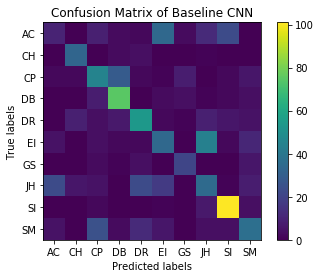

In [87]:
labels = ['AC', 'CH', 'CP', 'DB', 'DR', 'EI', 'GS', 'JH', 'SI', 'SM']
cm = confusion_matrix([labels[i] for i in test_gen.classes[:896]], \
                      [labels[j] for j in predicted_class_indices], \
                      labels)

# plt.imshow(cm)
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")

# plt.xticks(np.arange(0,10),labels)
# plt.yticks(np.arange(0,10),labels)
# plt.title('Confusion Matrix of Baseline CNN')
# plt.colorbar()
# plt.savefig(os.path.join(opts.plot_save_path, "cm(baseline)"), bbox_inches='tight')

# plt.show()

#Fetch labels from train gen for testing
# labels = (train_gen.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

In [92]:
def plot_confusion_matrix(cm,
                          target_names,
                          opts,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
        -----
        plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                                  # sklearn.metrics.confusion_matrix
                              normalize    = True,                # show proportions
                              target_names = y_labels_vals,       # list of names of the classes
                              title        = best_estimator_name) # title of graph

        Citiation
        ---------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

        """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(os.path.join(opts.plot_save_path, title), bbox_inches='tight')
    plt.show()

In [93]:
plot_confusion_matrix(cm, 
                      opts,
                      labels,
                      normalize = False,
                      title = "Confusion Matrix of Baseline CNN")

TypeError: plot_confusion_matrix() got multiple values for argument 'target_names'

In [59]:
predicted_class_indices

array([[ 10,   0,   9,   3,   2,  34,   3,  12,  23,   0],
       [  0,  33,   0,   3,   4,   0,   0,   1,   0,   0],
       [  2,   2,  45,  29,   2,   1,   8,   0,   2,   6],
       [  0,   0,   8,  75,   0,   3,   4,   1,   2,   4],
       [  0,   9,   4,   7,  54,   2,   1,   9,   6,   5],
       [  5,   0,   4,   2,   2,  34,   0,  44,   2,  11],
       [  0,   0,   3,   1,   4,   0,  21,   0,   0,   6],
       [ 23,   6,   5,   0,  23,  17,   0,  35,   1,   8],
       [  0,   0,   2,   0,   0,   1,   0,   7, 101,   4],
       [  5,   0,  25,   3,  12,   6,   0,   4,   4,  37]])